This is the 1st part of my mini series relating to Detecting Respiratory Disease with the use of Respiratory Audio (breathing sounds). For this kernel, we're only going to slice each audio file into subslices which is defined by the txt files. 

- Part 2: [Split into train and test] (https://www.kaggle.com/danaelisanicolas/cnn-part-2-split-to-train-and-test)
- Part 3: [Create spectrogram images from audio] (https://www.kaggle.com/danaelisanicolas/cnn-part-3-create-spectrogram-images)
- Part 4: [Create and train a VGG16 model with the spec images] (https://www.kaggle.com/danaelisanicolas/cnn-part-4-training-and-modelling-with-vgg16)

Let's start.

Here you'll see that i'm importing librosa and soundfile which are python packages that deals with audio files.
* [Librosa] (https://librosa.github.io/librosa/)
* [Soundfile] (https://pysoundfile.readthedocs.io/en/latest/)

Boxplot_stats will be used later to see outliers. More of this later

In [1]:
import pandas as pd
import numpy as np
import math

import librosa as lb # https://librosa.github.io/librosa/
import soundfile as sf # https://pysoundfile.readthedocs.io/en/latest/

import os

import matplotlib.pyplot as plt
from matplotlib.cbook import boxplot_stats

I had to look first where the audio and text files are by using !ls

In [2]:
!ls ../input/respiratory-sound-database/respiratory_sound_database/Respiratory_Sound_Database

audio_and_txt_files	  filename_format.txt
filename_differences.txt  patient_diagnosis.csv


Load the patient diagnosis file first and check all the unique diagnosis we have in our data.

This is necessary in how we will sort our output later.

In [3]:
#load patient diagnosis.csv

diag_csv = '../input/respiratory-sound-database/respiratory_sound_database/Respiratory_Sound_Database/patient_diagnosis.csv'
diagnosis = pd.read_csv(diag_csv, names=['pId', 'diagnosis'])
diagnosis.head()

,pId,diagnosis
0,101,URTI
1,102,Healthy
2,103,Asthma
3,104,COPD
4,105,URTI


In [4]:
ds = diagnosis['diagnosis'].unique()
ds

array(['URTI', 'Healthy', 'Asthma', 'COPD', 'LRTI', 'Bronchiectasis',
       'Pneumonia', 'Bronchiolitis'], dtype=object)

Next we will need to read all the unique files in our dataset. This is done by using the os.listdir function with the condition of checking only .txt files.

Note: We can also use the condition to check .wav files. Eitherway we'll just check all unique files. Condition is needed because if we're checking all kinds of files, we may get replicates. Our dataset consists of .txt and its equivalent .wav files.

In [5]:
#get all text files
audio_text_loc = '../input/respiratory-sound-database/respiratory_sound_database/Respiratory_Sound_Database/audio_and_txt_files'
files = [s.split('.')[0] for s in os.listdir(path = audio_text_loc) if '.txt' in s]
files

['162_2b2_Ar_mc_AKGC417L',
 '110_1p1_Ll_sc_Meditron',
 '219_2b2_Ar_mc_LittC2SE',
 '167_1b1_Pr_sc_Meditron',
 '209_1b1_Tc_sc_Meditron',
 '195_1b1_Pr_sc_Litt3200',
 '138_1p2_Ll_mc_AKGC417L',
 '158_1b3_Ar_mc_LittC2SE',
 '201_1b2_Ar_sc_Meditron',
 '141_1b2_Lr_mc_LittC2SE',
 '133_2p4_Pl_mc_AKGC417L',
 '226_1b1_Ll_sc_Meditron',
 '207_2b3_Pr_mc_AKGC417L',
 '107_2b5_Lr_mc_AKGC417L',
 '205_3b4_Ar_mc_AKGC417L',
 '130_2b3_Al_mc_AKGC417L',
 '130_1p2_Pr_mc_AKGC417L',
 '107_2b4_Pr_mc_AKGC417L',
 '141_1b2_Ar_mc_LittC2SE',
 '151_2p3_Pl_mc_AKGC417L',
 '150_1b2_Al_sc_Meditron',
 '159_1b1_Ll_sc_Meditron',
 '200_2p2_Pl_mc_AKGC417L',
 '163_2b2_Tc_mc_AKGC417L',
 '200_2p3_Al_mc_AKGC417L',
 '160_1b3_Tc_mc_AKGC417L',
 '130_2b4_Lr_mc_AKGC417L',
 '205_1b3_Pr_mc_AKGC417L',
 '107_3p2_Al_mc_AKGC417L',
 '107_3p2_Ar_mc_AKGC417L',
 '147_2b3_Ar_mc_AKGC417L',
 '170_1b2_Pl_mc_AKGC417L',
 '188_1b1_Pl_sc_Meditron',
 '221_2b1_Al_mc_LittC2SE',
 '162_2b4_Pl_mc_AKGC417L',
 '156_8b3_Lr_mc_AKGC417L',
 '213_1p5_Al_mc_AKGC417L',
 

We know that our filenames have a certain meaning in them. We get all info (or tokens) by splitting the filename by using "_" as separators. We define a function to do this task.

In [6]:
def tokenize_file(filename):
    return filename.split('_')

Now that we have our files list, we have to read each one to get the crackles and wheezes information--including when in the audio file it is recorded (start and end time denoted in seconds).

I've created the files_df to compile all these data (which includes the patient id and acquisition mode--stereo or mono--which will be used later).

In [7]:
#read each file

files_ = []
for f in files:
    df = pd.read_csv(audio_text_loc + '/' + f + '.txt', sep='\t', names=['start', 'end', 'crackles', 'wheezes'])
    df['filename'] = f
    #get filename features
    f_features = tokenize_file(f)
    df['pId'] = f_features[0]
    df['ac_mode'] = f_features[3]
    
    files_.append(df)
    
files_df = pd.concat(files_)
files_df.reset_index()
files_df.head()

,start,end,crackles,wheezes,filename,pId,ac_mode
0,0.0750,3.898,0,0,162_2b2_Ar_mc_AKGC417L,162,mc
1,3.8980,10.109,0,0,162_2b2_Ar_mc_AKGC417L,162,mc
2,10.1090,16.753,0,0,162_2b2_Ar_mc_AKGC417L,162,mc
3,16.7530,19.090,0,0,162_2b2_Ar_mc_AKGC417L,162,mc
0,3.6457,7.601,0,1,110_1p1_Ll_sc_Meditron,110,sc


We want to combine the 2 dataframes we've made so far. However to do that, we have to make sure that the column where we'll combine them must have the same data type.

In this case I just changed the files_df pId column to float64 to be the same as the diagnosis pId dataframe. We can also use int32 to minimise the data allocation in our system however that'll not be our concern for now.

Once the 2 columns have the same data type, we'll use the pandas merge function to combine the 2 dataframes.

In [8]:
files_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6898 entries, 0 to 6
Data columns (total 7 columns):
start       6898 non-null float64
end         6898 non-null float64
crackles    6898 non-null int64
wheezes     6898 non-null int64
filename    6898 non-null object
pId         6898 non-null object
ac_mode     6898 non-null object
dtypes: float64(2), int64(2), object(3)
memory usage: 431.1+ KB


In [9]:
diagnosis.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 126 entries, 0 to 125
Data columns (total 2 columns):
pId          126 non-null int64
diagnosis    126 non-null object
dtypes: int64(1), object(1)
memory usage: 2.1+ KB


In [10]:
files_df['pId'] = files_df['pId'].astype('float64')
files_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6898 entries, 0 to 6
Data columns (total 7 columns):
start       6898 non-null float64
end         6898 non-null float64
crackles    6898 non-null int64
wheezes     6898 non-null int64
filename    6898 non-null object
pId         6898 non-null float64
ac_mode     6898 non-null object
dtypes: float64(3), int64(2), object(2)
memory usage: 431.1+ KB


In [11]:
files_df = pd.merge(files_df, diagnosis, on='pId')
files_df.head()

,start,end,crackles,wheezes,filename,pId,ac_mode,diagnosis
0,0.075,3.898,0,0,162_2b2_Ar_mc_AKGC417L,162.0,mc,COPD
1,3.898,10.109,0,0,162_2b2_Ar_mc_AKGC417L,162.0,mc,COPD
2,10.109,16.753,0,0,162_2b2_Ar_mc_AKGC417L,162.0,mc,COPD
3,16.753,19.090,0,0,162_2b2_Ar_mc_AKGC417L,162.0,mc,COPD
4,3.598,7.387,0,0,162_2b4_Pl_mc_AKGC417L,162.0,mc,COPD


We want to slice the wav file into subslices to get the pure breathing part of the audio file. Again, this is denoted by the start and end times mentioned in the txt files. 

I've defined the slice_data function to do this.

In [12]:
#code taken from eatmygoose https://www.kaggle.com/eatmygoose/cnn-detection-of-wheezes-and-crackles
def slice_data(start, end, raw_data,  sample_rate):
    max_ind = len(raw_data) 
    start_ind = min(int(start * sample_rate), max_ind)
    end_ind = min(int(end * sample_rate), max_ind)
    return raw_data[start_ind: end_ind]

So.. sure we can slice the audio files, but there are things we need to consider as well
- We need to make sure that they will have the same length (this is in preparation for feeding them into the model for training later)
- If they're not the same length, then we have to pad the audio with silent (or zeroes) sounds.
- For the length, we have to know what is the optimal length of time we should use.

For the next part I tried to get the max length per slice that we currently have in our dataframe

In [13]:
files_df['len_per_slice'] = files_df['end'].sub(files_df['start'], axis = 0) 
max_len_per_slice = max(files_df['len_per_slice'])
max_len_per_slice

16.163

16 seconds long? Is there someone who can have 1 breathe as long as 16 seconds? No, obviously.

So we try and understand our data and check the outliers and the relative maximum of the dataset.

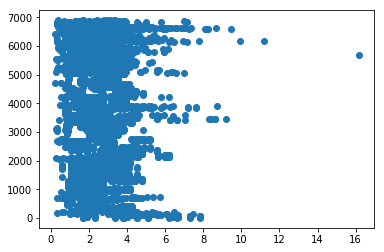

In [14]:
plt.scatter(files_df['len_per_slice'], y=files_df.index)

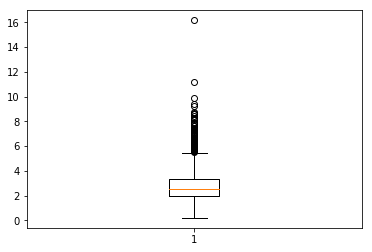

In [15]:
box = plt.boxplot(files_df['len_per_slice'])

And define the forced maximum length force_max_len as round up of the relative max (5.48 sec round up to 6 sec) length of time.

In [16]:
force_max_len = math.ceil(boxplot_stats(files_df['len_per_slice'])[0]['whishi'])
force_max_len

6

Next is we have to compute the length of the raw data of the slices. I defined a function compute_len to do this.

Remember we had to store the acquisition mode? It's because it has different computation for stereo and mono.
- Stereo: (Sampling rate * time) * 2
- Mono: (Sampling rate * time)

In [17]:
def compute_len(samp_rate=22050, time=force_max_len, acquisition_mode=0):
    '''Computes the supposed length of sliced data
        samp_size = sample size from the data
        samp_rate = sampling rate. by default since we're working on 24-bit files, we'll use 96kHz
        time = length of time for the audio file. by default we'll use the max we have which is 5.48
        acquisition_mode = either mono or stereo. 0 for mono, 1 for stereo
    '''
    comp_len = 0
    if acquisition_mode == 0: #mono
        comp_len = samp_rate * time
    else: #stereo
        comp_len = (samp_rate * time) * 2

    return comp_len

We're almost ready to create new wav files based on the slices. There's one more problem: we must prepare where to store these new wav files.

So we have to create our output directory and subfolders as defined by the unique diagnosis.

In [18]:
#create output path
os.makedirs('output')

In [19]:
for d in ds:
    path = os.path.join('output', d)
    os.makedirs(path)

Which we can now check using !ls

In [20]:
!ls

__notebook__.ipynb  output


Alright time to roll! Now that everything is set, let's start processing the files now. 

The first thing you might notice is the declaration of the i = 0. This will be used in saving of files later. As you may know, each wav file will consist of different slices. When saving these slices, we'll add the ith number of slice. For example, 104_1b1_Ll_sc_Litt3200.wav might have 4 slices, so we'll save them as 
- 104_1b1_Ll_sc_Litt3200_0, 
- 104_1b1_Ll_sc_Litt3200_1, 
- 104_1b1_Ll_sc_Litt3200_2, 
- 104_1b1_Ll_sc_Litt3200_3

Next, for each file 
- get the filename (which will be used for saving later)
- get the start and end times for the processing of the sliced wav files
- get the diagnosis so we'll know which subfolder we'll save the sliced wav file

If the slice is greater than force_max_len, force the slice to only be force_max_len long.

Using the librosa function load, load the wav file which returns raw data and the sampling rate.
Then we feed the raw data to the compute_len function we defined earlier to get the expected length of data.
Pad the sliced audio with zeroes using the librosa function util.pad_center.
Then finally, save this file to our destination path which includes which subfolder we'll save it.

TLDR;
- Read the audio file
- Slice the audio file
- Pad in case it's less than 6 sec
- Save

In [21]:
i = 0 #iterator for file naming

for idx, row in files_df.iterrows():
    filename = row['filename']
    start = row['start']
    end = row['end']
    diag = row['diagnosis']
    
    #check len and force to 6 sec if more than that
    if force_max_len < end - start:
        end = start + force_max_len
    
    aud_loc = audio_text_loc + '/' + f + '.wav'
    
    if idx != 0:
        if files_df.iloc[idx-1]['filename'] == filename:
            i=i+1
        else:
            i=0
    n_filename = filename + '_' + str(i) + '.wav'
    path = 'output/' + diag + '/' + n_filename
    
    print('processing ' + n_filename + '...')

    data, samplingrate = lb.load(aud_loc)
    sliced_data = slice_data(start=start, end=end, raw_data=data, sample_rate=samplingrate)
    
    #pad audio if < forced_max_len
    a_len = compute_len(samp_rate=samplingrate, acquisition_mode=row['ac_mode']=='sc')
    padded_data = lb.util.pad_center(sliced_data, a_len)

    sf.write(file=path, data=padded_data, samplerate=samplingrate)


processing 162_2b2_Ar_mc_AKGC417L_0.wav...
processing 162_2b2_Ar_mc_AKGC417L_1.wav...
processing 162_2b2_Ar_mc_AKGC417L_2.wav...
processing 162_2b2_Ar_mc_AKGC417L_3.wav...
processing 162_2b4_Pl_mc_AKGC417L_0.wav...
processing 162_2b4_Pl_mc_AKGC417L_1.wav...
processing 162_2b4_Pl_mc_AKGC417L_2.wav...
processing 162_2b4_Pl_mc_AKGC417L_3.wav...
processing 162_1b2_Pr_mc_AKGC417L_0.wav...
processing 162_1b2_Pr_mc_AKGC417L_1.wav...
processing 162_1b2_Pr_mc_AKGC417L_2.wav...
processing 162_2b4_Tc_mc_AKGC417L_0.wav...
processing 162_2b4_Tc_mc_AKGC417L_1.wav...
processing 162_2b4_Tc_mc_AKGC417L_2.wav...
processing 162_2b4_Tc_mc_AKGC417L_3.wav...
processing 162_1b2_Tc_mc_AKGC417L_0.wav...
processing 162_1b2_Tc_mc_AKGC417L_1.wav...
processing 162_1b2_Tc_mc_AKGC417L_2.wav...
processing 162_1b2_Lr_mc_AKGC417L_0.wav...
processing 162_1b2_Lr_mc_AKGC417L_1.wav...
processing 162_1b2_Lr_mc_AKGC417L_2.wav...
processing 162_2b3_Lr_mc_AKGC417L_0.wav...
processing 162_2b3_Lr_mc_AKGC417L_1.wav...
processing 

Then it's done! We can check using !ls again

In [22]:
!ls output/

Asthma	Bronchiectasis	Bronchiolitis  COPD  Healthy  LRTI  Pneumonia  URTI
